In [1]:
# docker run --gpus all -it -v $(realpath ~/):/tf/All -v /home/rob/Data2:/home/rob/Data2 --env HF_DATASETS_CACHE=/home/rob/Data2/huggingface/datasets --env TRANSFORMERS_CACHE=/home/rob/Data2/huggingface/transformers -p 8888:8888 -p 6006:6006 d139afc9cfb2

# This generates 2 files into the glove_embeddings folder ... 

# 2nd pass, with generate_cooc = False.
# Run Date: Thursday, January 19, 2023
# Run Time: 00:01:57

# First Pass ... 
# Cell 8 was set to ...
# generate_cooc = True
# ... which generates the 'cooc_mat.npz' file into the data subfolder ...
# Run Date: Thursday, January 19, 2023
# Run Time: 00:08:59


In [2]:
import time
from datetime import date

startTime = time.time()
todaysDate = date.today()

In [3]:
# only target the 2070 Super ...
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# GloVe: Global Vectors for Word2Vec

<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/packt_nlp_tensorflow_2/blob/master/Ch04-Advance-Word-Vectors/ch4_glove.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>

In [4]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from six.moves.urllib.request import urlretrieve
import zipfile
import numpy as np
import pandas as pd
import os
import time
import random
import tensorflow as tf
from matplotlib import pylab
from scipy.sparse import lil_matrix

2023-01-19 16:40:53.808928: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 16:40:54.374878: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-19 16:40:54.374927: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-19 16:40:54.374934: W tensorfl

## Understanding the data

### Downloading the data

This code downloads a [BBC dataset](hhttp://mlg.ucd.ie/files/datasets/bbc-fulltext.zip) consisting of news articles published by BBC. 

In [5]:
url = 'http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip'


def download_data(url, data_dir):
    """Download a file if not present, and make sure it's the right size."""
    
    # Create the data directory if not exist
    os.makedirs(data_dir, exist_ok=True)

    file_path = os.path.join(data_dir, 'bbc-fulltext.zip')
    
    # If file doesnt exist, download
    if not os.path.exists(file_path):
        print('Downloading file...')
        filename, _ = urlretrieve(url, file_path)
    else:
        print("File already exists")
  
    extract_path = os.path.join(data_dir, 'bbc')
    
    # If data has not been extracted already, extract data
    if not os.path.exists(extract_path):        
        with zipfile.ZipFile(os.path.join(data_dir, 'bbc-fulltext.zip'), 'r') as zipf:
            zipf.extractall(data_dir)
    else:
        print("bbc-fulltext.zip has already been extracted")
    
download_data(url, 'data')

File already exists
bbc-fulltext.zip has already been extracted


### Read Data without Preprocessing 

Here we read all the files and keep them as a list of strings, where each string is a single article

In [6]:
def read_data(data_dir):
    
    # This will contain the full list of stories
    news_stories = []
    
    print("Reading files")
    
    i = 0 # Just used for printing progress
    for root, dirs, files in os.walk(data_dir):
        
        for fi, f in enumerate(files):
            
            # We don't read the readme file
            if 'README' in f:
                continue
            
            # Printing progress
            i += 1
            print("."*i, f, end='\r')
            
            # Open the file
            with open(os.path.join(root, f), encoding='latin-1') as f:
                
                story = []
                # Read all the lines
                for row in f:
                                        
                    story.append(row.strip())
                    
                # Create a single string with all the rows in the doc
                story = ' '.join(story)                        
                # Add that to the list
                news_stories.append(story)  
                
        print('', end='\r')
        
    print(f"\nDetected {len(news_stories)} stories")
    return news_stories
                
  
news_stories = read_data(os.path.join('data', 'bbc'))

# Printing some stats and sample data
print(f"{sum([len(story.split(' ')) for story in news_stories])} words found in the total news set")
print('Example words (start): ',news_stories[0][:50])
print('Example words (end): ',news_stories[-1][-50:])

Reading files
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Build a Tokenizer

Here we build a tokenizer, that performs simple preprocessing like,

* Converting letters to lower case
* Removing punctuation

and tokenize the strings based on a defined separator. Then each token is converted to an Integer ID, as computers understand numbers, not strings. In the background, the tokenizer builds a word to index dictionary, that defines a unique ID for each word in the vocabulary.

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

n_vocab = 15000 + 1
tokenizer = Tokenizer(
    num_words=n_vocab - 1,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', oov_token=''
)

tokenizer.fit_on_texts(news_stories)
print("Data fitted on the tokenizer")

Data fitted on the tokenizer


## Generating the word co-occurrence matrix

Why GloVe shine above context window based method is that it employs global statistics of the corpus in to the model (according to authors). This is done by using information from the word co-occurance matrix to optimize the word vectors. Basically, the $X(i,j)$ entry of the co-occurance matrix says how frequent word $i$ to appear near $j$. 

We also use an optional weighting mechanishm to give more weight to words close together than to the ones further-apart (from experiments section of the paper).

**Note**: When generating the matrix for the first time, it will take a significant amount of time to run

In [8]:
from scipy.sparse import save_npz, load_npz

def generate_cooc_matrix(text, tokenizer, window_size, n_vocab, use_weighting=True):
    
    # Convert list of text to list of list of word IDs
    sequences = tokenizer.texts_to_sequences(text)
    
    # A sparse matrix to retain co-occurrences of words
    cooc_mat = lil_matrix((n_vocab, n_vocab), dtype=np.float32)
    
    # Go through each sequence one by one
    for si, sequence in enumerate(sequences):
        
        # Printing the progress
        if (si+1)%100==0:
            print('.'*((si+1)//100), f"{si+1}/{len(sequences)}", end='\r')
        
        # For each target word,
        for i, wi in zip(np.arange(window_size, len(sequence)-window_size), sequence[window_size:-window_size]):
            
            # Get the context window word IDs
            context_window = sequence[i-window_size: i+window_size+1]            
            
            # The weight for the words in the context window (except target word) will be 1
            window_weights = np.ones(shape=(window_size*2 + 1,), dtype=np.float32)
            window_weights[window_size] = 0.0

            if use_weighting:
                # If weighting is used, penalize context words based on distance to target word
                distances = np.abs(np.arange(-window_size, window_size+1))
                distances[window_size] = 1.0
                # Update the sparse matrix
                cooc_mat[wi, context_window] += window_weights/distances
            else:
                # Update the sparse matrix
                cooc_mat[wi, context_window] += window_weights
    
    print("\n")
    
    return cooc_mat    

# ----------------------------------------- IMPORTANT ---------------------------------------------- #
#                                                                                                    #
# Set this true or false, depending on whether you want to generate the matrix or reuse the existing #
#                                                                                                    #
# ---------------------------------------------------------------------------------------------------#
generate_cooc = False

# Generate the matrix
if generate_cooc:
    t1 = time.time()
    cooc_mat = generate_cooc_matrix(news_stories, tokenizer, 1, n_vocab, True)
    t2 = time.time()
    print(f"It took {t2-t1} seconds to generate the co-occurrence matrix")
    
    save_npz(os.path.join('data','cooc_mat.npz'), cooc_mat.tocsr())
# Load the matrix from disk
else:
    try:
        cooc_mat = load_npz(os.path.join('data','cooc_mat.npz')).tolil()
        print(f"Cooc matrix of type {type(cooc_mat).__name__} was loaded from disk")
    except FileNotFoundError as ex:
        raise FileNotFoundError(
            "Could not find the co-occurrence matrix on the disk. Did you generate the matrix by setting generate_cooc=True?"
        )

Cooc matrix of type lil_matrix was loaded from disk


## Checking the validity of the co-occurrence matrix

Here we will see if the context around a given word has sensible words appearing in it

([<matplotlib.axis.XTick at 0x7f94e94b6850>,
 [Text(0, 0, 'jaime'),
  Text(1, 0, 'you'),
  Text(2, 0, 'she'),
  Text(3, 0, 'understands'),
  Text(4, 0, 'it'),
  Text(5, 0, 'he'),
  Text(6, 0, 'said'),
  Text(7, 0, 'cas'),
  Text(8, 0, 'i'),
  Text(9, 0, 'website'),
  Text(10, 0, 'we'),
  Text(11, 0, 'school'),
  Text(12, 0, 'wales'),
  Text(13, 0, "it's"),
  Text(14, 0, 'on'),
  Text(15, 0, 'that'),
  Text(16, 0, 'is'),
  Text(17, 0, 'a'),
  Text(18, 0, ''),
  Text(19, 0, 'of'),
  Text(20, 0, 'in'),
  Text(21, 0, 'and'),
  Text(22, 0, 'for'),
  Text(23, 0, 'the'),
  Text(24, 0, 'bbc')])

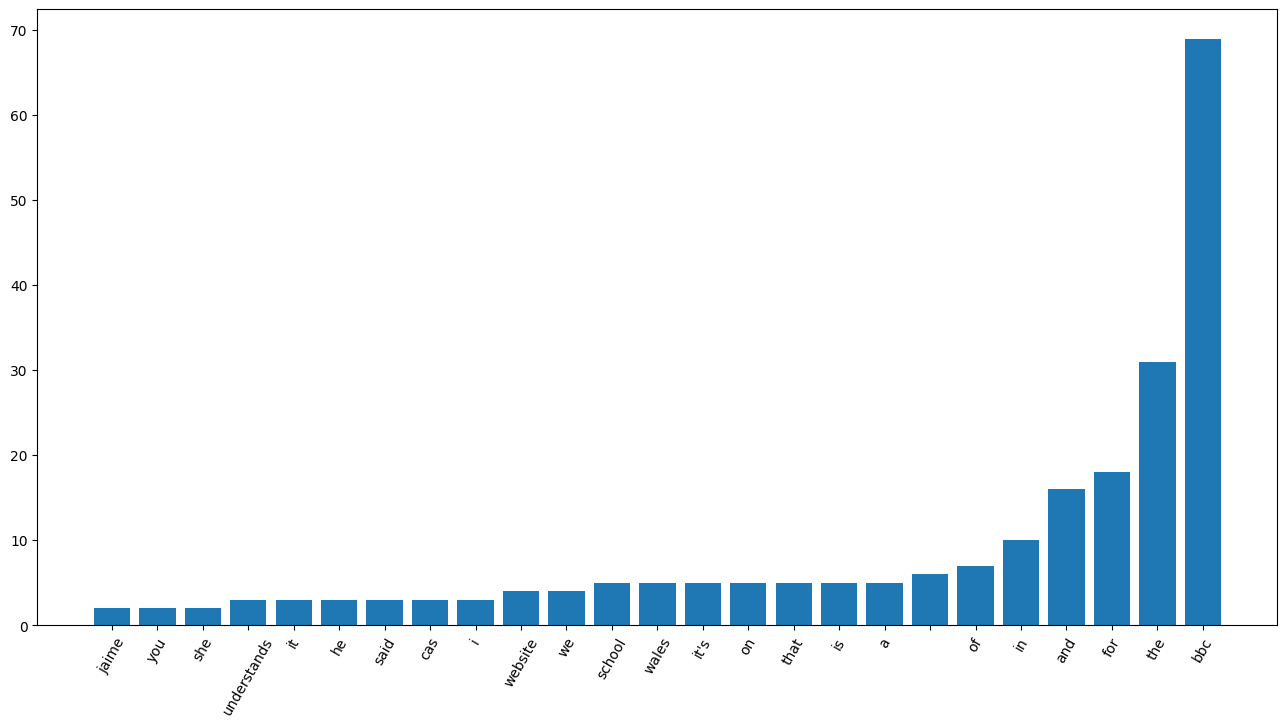

In [9]:
import matplotlib.pyplot as plt

word = 'sport'
assert word in tokenizer.word_index, f"Word {word} is not in the tokenizer"
assert tokenizer.word_index[word] <= n_vocab, f"The word {word} is an out of vocabuary word. Please try something else"

# Get the vector of co-occurrences for a given word 
cooc_vec = np.array(cooc_mat.getrow(tokenizer.word_index[word]).todense()).ravel()
# Get indices of words with maximum value
max_ind = np.argsort(cooc_vec)[-25:]

# Plot the words and values
plt.figure(figsize=(16,8))
plt.bar(np.arange(0, 25), cooc_vec[max_ind])
plt.xticks(ticks=np.arange(0, 25), labels=[tokenizer.index_word[i] for i in max_ind], rotation=60)

## GloVe Algorithm

### Defining Hyperparameters

Here we define several hyperparameters including `batch_size` (amount of samples in a single batch) `embedding_size` (size of embedding vectors) `window_size` (context window size).

In [10]:
batch_size = 4096 # Data points in a single batch

embedding_size = 128 # Dimension of the embedding vector.

window_size=1 # We use a window size of 1 on either side of target word

epochs = 5 # Number of epochs to train for

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 250

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
np.random.seed(54321)
random.seed(54321)

valid_term_ids = np.array(random.sample(range(valid_window), valid_size))
valid_term_ids = np.append(
    valid_term_ids, random.sample(range(1000, 1000+valid_window), valid_size),
    axis=0
)

### Defining the Model Computations

The model takes two inputs,

* A (batch of) context word ID(s) - $i$
* A (batch of) target word ID(s) - $j$

and computes the following output,

$w_i.\tilde{w}_j + b_i + \tilde{b}_j$

where, $w_i$ is the context embeddings for the words in $i$, $\tilde{w}_j$ is target embeddings for the words in $j$, $b_i$ and $\tilde{b}_j$ are two separate biases for context and target spaces. Then the following loss function is used,

$J = f(X_{ij}) \sum_{i,j=1}^{V} (w_i\tilde{w}_j + b_i + \tilde{b}_j - log(X_{ij})^2$

Here, X_{ij} is the value at (i,j) position in the co-occurrence matrix and f(X_{ij}) is a simple weighting function of X_{ij}. You can see that the loss function looks of the format,

$J = A ( B - C ) ^ 2 $

Therefore, we will use the mean-squared-error loss and feed in $f(X_{ij})$ values as sample weights during training.

---
*The behavior of the GloVe word vectors*

![The behavior of the GloVe word vectors](notebook_images/04_01.png)

In [11]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Embedding, Dot, Add
from tensorflow.keras.models import Model

K.clear_session()

# Define two input layers for context and target words
word_i = Input(shape=())
word_j = Input(shape=())

# Each context and target has their own embeddings (weights and biases)

# Embedding weights
embeddings_i = Embedding(n_vocab, embedding_size, name='target_embedding')(word_i)
embeddings_j = Embedding(n_vocab, embedding_size, name='context_embedding')(word_j)

# Embedding biases
b_i = Embedding(n_vocab, 1, name='target_embedding_bias')(word_i)    
b_j = Embedding(n_vocab, 1, name='context_embedding_bias')(word_j)

# Compute the dot product between embedding vectors (i.e. w_i.w_j)
ij_dot = Dot(axes=-1)([embeddings_i,embeddings_j])

# Add the biases (i.e. w_i.w_j + b_i + b_j )
pred = Add()([ij_dot, b_i, b_j])

# The final model
glove_model = Model(inputs=[word_i, word_j],outputs=pred, name='glove_model')

# Glove has a specific loss function with a sound mathematical underpinning
# It is a form of mean squared error
glove_model.compile(loss="mse", optimizer = 'adam')

glove_model.summary()

Model: "glove_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 target_embedding (Embedding)   (None, 128)          1920128     ['input_1[0][0]']                
                                                                                                  
 context_embedding (Embedding)  (None, 128)          1920128     ['input_2[0][0]']                
                                                                                        

2023-01-19 16:40:55.959930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 16:40:55.963832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 16:40:55.964034: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 16:40:55.964365: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

## Generating data for GloVe model

The Glove model we implemented, 

* Takes two inputs; context words and target words 
* Computes the mean squared error as, $(\hat{y}_{ij} - log(X_{ij}))^2$ for the model output $\hat{y}_{ij}$
* Use sample weights returned by $f(X_{ij})$

Therefore, in the data generator we return a tuple of,

`(inputs, targets, sample weights)`

which translates to,

`((batch of target words, batch or context words), batch of log(X_{ij}), batch of f(X_{ij})`                                

In [12]:
news_sequences = tokenizer.texts_to_sequences(news_stories)

In [13]:
def glove_data_generator(
    sequences, window_size, batch_size, vocab_size, cooccurrence_matrix, x_max=100.0, alpha=0.75, seed=None
):
    """ Generate batches of inputs and targets for GloVe """
    
    # Shuffle the data so that, every epoch, the order of data is different
    rand_sequence_ids = np.arange(len(sequences))                    
    np.random.shuffle(rand_sequence_ids)

    # We will use a sampling table to make sure, we don't oversample stopwords
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)
    
    # For each story/article
    for si in rand_sequence_ids:
        
        # Generate positive skip-grams while using sub-sampling 
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequences[si], 
            vocabulary_size=vocab_size, 
            window_size=window_size, 
            negative_samples=0.0, 
            shuffle=False,   
            sampling_table=sampling_table,
            seed=seed
        )
        
        # Take targets and context words separately
        targets, context = zip(*positive_skip_grams)
        targets, context = np.array(targets).ravel(), np.array(context).ravel()
        
        
        x_ij = np.array(cooccurrence_matrix[targets, context].toarray()).ravel()
        
        # Compute log - Introducing an additive shift to make sure we don't compute log(0)
        log_x_ij = np.log(x_ij + 1)
        
        # Sample weights 
        # if x < x_max => (x/x_max)**alpha / else => 1        
        sample_weights = np.where(x_ij < x_max, (x_ij/x_max)**alpha, 1)
        
        # If seed is not provided generate a random one
        if not seed:
            seed = random.randint(0, 10e6)
        
        # Shuffle data
        np.random.seed(seed)
        np.random.shuffle(context)
        np.random.seed(seed)
        np.random.shuffle(targets)
        np.random.seed(seed)
        np.random.shuffle(log_x_ij)
        np.random.seed(seed)
        np.random.shuffle(sample_weights)
        
        # Generate a batch or data in the format 
        # ((target words, context words), log(X_ij) <- true targets, f(X_ij) <- sample weights)
        for eg_id_start in range(0, context.shape[0], batch_size):            
            yield (
                targets[eg_id_start: min(eg_id_start+batch_size, targets.shape[0])], 
                context[eg_id_start: min(eg_id_start+batch_size, context.shape[0])]
            ), log_x_ij[eg_id_start: min(eg_id_start+batch_size, x_ij.shape[0])], \
            sample_weights[eg_id_start: min(eg_id_start+batch_size, sample_weights.shape[0])]


# Generate some data
news_glove_data_gen = glove_data_generator(
    news_sequences, 2, 10, n_vocab, cooc_mat
)

for x, y, z in news_glove_data_gen:
    print(x)
    print(y)
    print(z)
    break

(array([9421, 1983, 3399, 6105,  297,  311, 7354, 3301, 3399, 1305]), array([  71, 2152,    6,   30,   12,  351,    7,  219,  478,  198]))
[0.6931472 0.6931472 0.6931472 0.        2.7725887 0.        0.6931472
 0.        0.        0.       ]
[0.03162277 0.03162277 0.03162277 0.         0.24102853 0.
 0.03162277 0.         0.         0.        ]


## Training the model

Here we train the GloVe model we defined above. We train for `epochs` and at the end of each epoch, we compute word similarities on a set of chosen validation words (`valid_term_ids`). Similar to in Chapter 3, we use a Keras callback to compute the most similar words.

### Calculating Word Similarities

We calculate the similarity between two given words in terms of the cosine distance. To do this efficiently we use matrix operations to do so, as shown below. Furthermore, we define the computations as a callback, which will automatically run at the end of an epoch during model training.

In [14]:
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, valid_term_ids, model_with_embeddings, tokenizer):
        
        self.valid_term_ids = valid_term_ids
        self.model_with_embeddings = model_with_embeddings
        self.tokenizer = tokenizer
        
        super().__init__()
        
    def on_epoch_end(self, epoch, logs=None):
        """ Validation logic """
                
        # We will use context embeddings to get the most similar words
        # Other strategies include: using target embeddings, mean embeddings after avaraging context/target
        embedding_weights = self.model_with_embeddings.get_layer("context_embedding").get_weights()[0]
        normalized_embeddings = embedding_weights / np.sqrt(np.sum(embedding_weights**2, axis=1, keepdims=True))
        
        # Get the embeddings corresponding to valid_term_ids
        valid_embeddings = normalized_embeddings[self.valid_term_ids, :]
        
        # Compute the similarity between valid_term_ids and all the embeddings
        # V x d (d x D) => V x D
        top_k = 5 # Top k items will be displayed
        similarity = np.dot(valid_embeddings, normalized_embeddings.T)
        
        # Invert similarity matrix to negative
        # Ignore the first one because that would be the same word as the probe word
        similarity_top_k = np.argsort(-similarity, axis=1)[:, 1: top_k+1]
                
        # Print the output
        for i, term_id in enumerate(valid_term_ids):
            
            similar_word_str = ', '.join([self.tokenizer.index_word[j] for j in similarity_top_k[i, :] if j > 1])
            print(f"{self.tokenizer.index_word[term_id]}: {similar_word_str}")
        
        print('\n')

In [15]:
glove_validation_callback = ValidationCallback(valid_term_ids, glove_model, tokenizer)

# Train the model for several epochs
for ei in range(epochs):
    
    print(f"Epoch: {ei+1}/{epochs} started")
    
    news_glove_data_gen = glove_data_generator(
        news_sequences, window_size, batch_size, n_vocab, cooc_mat
    )
    
    glove_model.fit(
        news_glove_data_gen, epochs=1, 
        callbacks=glove_validation_callback,        
    )

Epoch: 1/5 started


2023-01-19 16:40:57.969597: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1ea3d650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-19 16:40:57.969632: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-01-19 16:40:57.973269: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-19 16:40:58.087128: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   2215/Unknown - 69s 31ms/step - loss: 0.5989election: attorney, motors, director, manager, network
me: him, comes, us, win, japan
with: together, reached, shared, very, straight
you: we, they, also, still, now
were: but, are, was, is, if
win: us, time, parliament, comes, cases
those: which, but, plans, won, performed
music: cameras, came, choice, figures, one
also: made, they, now, used, but
international: my, or, took, irish, us
best: category, supporting, original, growing, bafta
him: another, comes, role, game, any
too: so, how, very, some, fair
into: current, straight, over, from, good
through: into, over, current, straight, from
mr: tony, gordon, resignation, jack, cherie
stay: win, value, parliament, work, which
kept: playing, won, urban, sixth, japan
agreement: victory, information, comes, him, ways
australia: 2005, comes, fans, us
unit: took, one, service, all, thompson
serious: game, broadband, movie, pre, or
field: game, issue, my, independent
debate: time, thursday, win, d

## Saving the embeddings
We save the learned embeddings to the disk

In [16]:
def save_embeddings(model, tokenizer, vocab_size, save_dir):
    
    # Create the directory if doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Get the words sorted according to their ID from the tokenizer
    _, words_sorted = zip(*sorted(list(tokenizer.index_word.items()), key=lambda x: x[0])[:vocab_size-1])
    # Add one word in front to represent the reserved ID (0)
    words_sorted = [None] + list(words_sorted)
    
    # Create a new array by concatenating embeddings and bias
    
    context_embedding_weights = model.get_layer("context_embedding").get_weights()[0]
    context_embedding_bias = model.get_layer("context_embedding_bias").get_weights()[0]
    context_embedding = np.concatenate([context_embedding_weights, context_embedding_bias], axis=1)
    
    target_embedding_weights = model.get_layer("target_embedding").get_weights()[0]
    target_embedding_bias = model.get_layer("target_embedding_bias").get_weights()[0]
    target_embedding = np.concatenate([target_embedding_weights, target_embedding_bias], axis=1)
    
    # Save the array as a Pandas DataFrames
    pd.DataFrame(
        context_embedding, 
        index = words_sorted
    ).to_pickle(os.path.join(save_dir, "context_embedding_and_bias.pkl"))
    
    pd.DataFrame(
        target_embedding, 
        index = words_sorted
    ).to_pickle(os.path.join(save_dir, "target_embedding_and_bias.pkl"))

    
save_embeddings(glove_model, tokenizer, n_vocab, save_dir='glove_embeddings')

In [17]:
endTime = time.time()
elapsedTime = time.strftime("%H:%M:%S", time.gmtime(endTime - startTime))

print(todaysDate.strftime('# Run Date: %A, %B %d, %Y'))
print(f"# Run Time: {elapsedTime}")

# Run Date: Thursday, January 19, 2023
# Run Time: 00:01:57
